# House prices

Sales prices prediction using an artificial neural network in Keras.

Source: Ames Housing dataset ([Kaggle website](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)).  




In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import helper

np.random.seed(9)
sns.set()

## Load and prepare the data

In [2]:
train_data_path = 'data/house_prices_data.csv'
df = pd.read_csv(train_data_path)
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
#print("Fields: \n {}".format(list(df)))   
print("Sample of categorical features: ")
examples = ['Alley', 'BsmtQual']
for e in examples:
    print("{}: {}".format(e,df[e].unique()))

Sample of categorical features: 
Alley: [nan 'Grvl' 'Pave']
BsmtQual: ['Gd' 'TA' 'Ex' nan 'Fa']


In [4]:
targets = ['SalePrice']
features = [field for field in df if field not in targets]

# remove non-significant features
features.remove('Id') 

df = df[features + targets]

# convert dataframe values to numerical
# df = df.apply(pd.to_numeric, errors='coerce')

categorical = [feat for feat in features if df[feat].dtype == 'object']
numerical = [feat for feat in features if df[feat].dtype != 'object']

# Reeplace NaN values
df.fillna(df[numerical].mean(), inplace=True)  # NaN from numerical feature replaced by mean
df = df.replace(np.nan, 'No Data', regex=True)  # NaN from categorical feature replaced by 'No Data'

#df[numerical].dtypes

### Visualize the data

(34900, 600000)

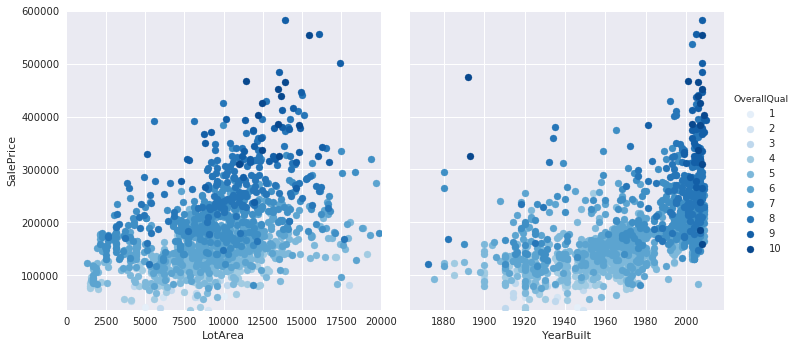

In [5]:
g = sns.PairGrid(df, y_vars=["SalePrice"], x_vars=["LotArea", "YearBuilt"], size=5, hue='OverallQual', palette = "Blues")
g.map(plt.scatter).add_legend()
g.axes[0,0].set_xlim(0,20000)
plt.ylim(df['SalePrice'].min(), 600000)

Lower sale prices are usually found in very low overall quality houses, with less dependency on its size and the year of construction. These three features alone are insufficient to make a good price prediction.

### Create dummy variables

In [6]:
dummy_fields = categorical

# Process categorical variables 
dummy_fields = [d for d in dummy_fields if d in df]
for each in dummy_fields:
    dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
    df = pd.concat([df, dummies], axis=1)
df = df.drop(dummy_fields, axis='columns')
df.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,0,0,1,0,0,0,0,1,0
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,0,0,0,1,0,0,0,0,1,0
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,0,0,1,0,0,0,0,1,0
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,0,0,1,1,0,0,0,0,0
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,0,0,0,1,0,0,0,0,1,0


### Scale numerical variables
The scaling factors are saved so we can go backwards when we use the network for predictions.

In [7]:
quant_features = numerical

# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for f in quant_features:
    mean, std = df[f].mean(), df[f].std()
    scaled_features[f] = [mean, std]
    df.loc[:, f] = (df[f] - mean)/std

scaled_targets = {}
for f in targets:
    mean, std = df[f].mean(), df[f].std()
    scaled_targets[f] = [mean, std]
    df.loc[:, f] = (df[f] - mean)/std    
    
df.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.073350,-0.229293,-0.207071,0.651256,-0.517023,1.050634,0.878367,0.511243,0.575228,-0.288554,...,0,0,0,1,0,0,0,0,1,0
1,-0.872264,0.451781,-0.091855,-0.071812,2.178881,0.156680,-0.429430,-0.574214,1.171591,-0.288554,...,0,0,0,1,0,0,0,0,1,0
2,0.073350,-0.093078,0.073455,0.651256,-0.517023,0.984415,0.829930,0.322950,0.092875,-0.288554,...,0,0,0,1,0,0,0,0,1,0
3,0.309753,-0.456318,-0.096864,0.651256,-0.517023,-1.862993,-0.720051,-0.574214,-0.499103,-0.288554,...,0,0,0,1,1,0,0,0,0,0
4,0.073350,0.633401,0.375020,1.374324,-0.517023,0.951306,0.733056,1.364102,0.463410,-0.288554,...,0,0,0,1,0,0,0,0,1,0


### Tune features selection
Fast way to remove features before training the model

In [8]:
fields_to_drop = []
data = df.drop(fields_to_drop, axis=1)
# filtered dataset now in 'data'

### Split the data into training and test sets

In [9]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data,  test_size=0.2, random_state=9)

# Separate the data into features and targets (x=features, y=targets)
x_train, y_train = train.drop(targets, axis=1).values, train[targets].values
x_test, y_test = test.drop(targets, axis=1).values, test[targets].values
test.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
1068,2.437384,-1.273607,-0.656513,-0.071812,-1.415657,0.057352,-0.574741,-0.574214,0.862447,-0.288554,...,0,0,0,1,0,0,0,0,1,0
271,-0.872264,0.133947,2.864083,0.651256,1.280247,-0.571727,0.975241,-0.574214,-0.477177,6.300863,...,0,0,0,1,0,0,0,0,1,0
39,0.782560,-0.229293,-0.448523,-1.517947,-0.517023,-0.538617,-1.446605,-0.574214,-0.972685,-0.288554,...,0,0,0,1,0,1,0,0,0,0
775,1.491770,-1.727657,-0.602812,-0.071812,-0.517023,0.885087,0.636183,1.197961,0.926029,-0.288554,...,0,0,0,1,0,0,0,0,1,0
247,-0.872264,0.224756,0.079466,-0.071812,-0.517023,-0.571727,-1.495042,-0.574214,-0.972685,-0.288554,...,0,0,0,1,0,0,0,0,1,0


## Deep Neural Network
  

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 152)               46360     
_________________________________________________________________
dropout_1 (Dropout)          (None, 152)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 153       
Total params: 46,513.0
Trainable params: 46,513.0
Non-trainable params: 0.0
_________________________________________________________________
Training ....
Epoch 00053: early stopping

Training loss:  	0.1201
Validation loss: 	0.2367


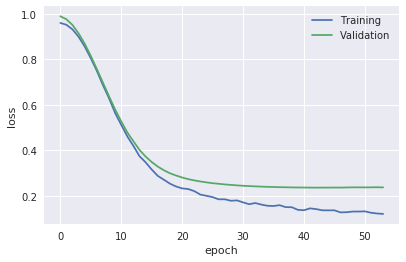

In [10]:
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout

nodes = x_train.shape[1]
weights = keras.initializers.RandomNormal(stddev=0.0001)

model = Sequential()
model.add(Dense(nodes//2, input_dim=x_train.shape[1], activation='relu',
               kernel_initializer=weights,
               bias_initializer = weights))
model.add(Dropout(.3))
model.add(Dense(1, activation=None,
               kernel_initializer = weights,
               bias_initializer = weights))
model.summary()

opt = keras.optimizers.adam(lr=0.00002)
model.compile(loss='mean_squared_error', optimizer=opt)

callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1)]
print('Training ....')
history = model.fit(x_train, y_train, epochs=10000, batch_size=16, verbose=0, 
                    validation_split=0.33, callbacks=callbacks)
helper.show_training(history)

### Make predictions

In [11]:
score = model.evaluate(x_test, y_test, verbose=1)
print("\n Test loss: {:.4f}".format(score))

 32/292 [==>...........................] - ETA: 0s
 Test loss: 0.1816


In [12]:
pred = model.predict(x_test, verbose=1)
restore_pred = pred * scaled_targets['SalePrice'][1] + scaled_targets['SalePrice'][0]
restore_pred = restore_pred.round()

restore_y = y_test * scaled_targets['SalePrice'][1] + scaled_targets['SalePrice'][0]
restore_y = restore_y.round()

pred_df = pd.DataFrame({'SalePrice': np.squeeze(restore_y), 
                              'Predicted SalePrice': np.squeeze(restore_pred)})

pred_df['Prediction error (%)'] = ((pred_df['Predicted SalePrice'] - pred_df['SalePrice']) * 100 
                                   /  pred_df['SalePrice']).round(1)
pred_df.head(10)

 32/292 [==>...........................] - ETA: 0s

,Predicted SalePrice,SalePrice,Prediction error (%)
0,217198.0,151400.0,43.5
1,195234.0,241500.0,-19.2
2,80091.0,82000.0,-2.3
3,179057.0,162000.0,10.5
4,143364.0,140000.0,2.4
5,216879.0,227000.0,-4.5
6,289096.0,228950.0,26.3
7,191631.0,208300.0,-8.0
8,125832.0,128500.0,-2.1
9,179710.0,165000.0,8.9


Prediction error:
Mean: 	 0.44%
Stddev:  12.98%


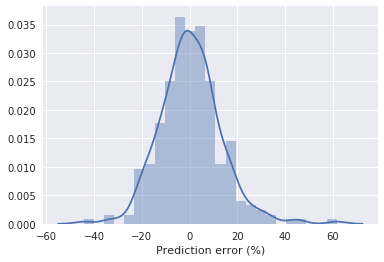

In [13]:
pred_error = pred_df['Prediction error (%)']

print("Prediction error:")
print("Mean: \t {:.2f}%".format(pred_error.mean()))
print("Stddev:  {:.2f}%".format(pred_error.std()))

sns.distplot(pred_error)

The error of the predicted sale prices can be modeled by a normal distribution, almost zero centered, and with a standard deviation of 13%. Thus, ~95% of the houses are predicted within a price error < 26% respect to the actual one. These results are not bad at all considering we are predicting the test houses, never used to train the model.